In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Обработка результатов

## **Изучение полученных результатов из УМ**

In [2]:
def get_result(config:str,
               way_type:str,
               fault:str,
               speed:int,
               profile:str = "gost") ->pd.DataFrame:
    """
    Получение результатов расчетов по ключевым словам
    1. `config` принимает два вида строк `empty` и `loaded`
    2. `way_type` принимает три вида строк `straight`, `curve_350` и `curve_650`
    3. `fault` принимает три вида строк `normal`, `polzun15`, `ellips10`
    4. `speed` от 10 до 60 км/ч
    5. `profile` есть профили `gost`, `newwagonw`, `greb_26`, `greb_30`, `greb_28`, `greb_24`
    """
    dictionary = {"curve_350":{20:55,
                               30:39,
                               40:28,
                               50:24,
                               60:19},
                }
    if config == "empty":
        PATH = "C:\\Users\\Daniil\\Desktop\\simulation_results\\empty"
    
    elif config == "loaded":
        PATH = "C:\\Users\\Daniil\\Desktop\\simulation_results\\loaded"
    
    name = "\\"+config+"_"+way_type+"_"+fault+"_"+str(speed)+"_"+profile+".csv"

    l_name = len(name)

    FULL_PATH = PATH+name

    file = pd.read_csv(FULL_PATH,encoding='latin-1')

    COL_NAMES = ["time_step",name[1:l_name-4]]

    file.columns = COL_NAMES

    file = file.set_index("time_step")

    if config == "curve_350":
        file = file[file.index<dictionary["curve_350"][speed]]

    
    return file


In [3]:
def get_profile_results(config:str,
                        way_type:str,
                        fault:str,
                        speed:int):
    """Результаты расчета по всем видам профилей"""
    file1 = get_result(config, way_type,fault,speed)
    file2 = get_result(config, way_type,fault,speed, "greb_26")
    file3 = get_result(config, way_type,fault,speed, "greb_28")
    file4 = get_result(config, way_type,fault,speed, "greb_30")
    file5 = get_result(config, way_type,fault,speed, "newwagonw")
    file6 = get_result(config, way_type,fault,speed, "greb_24")

    return file1,file2,file3,file4,file5, file6

In [4]:
def plot_profile_results(config:str,way_type:str,fault:str,speed:int):
    """Создание графика сравнения результатов с разным профилем колес"""
    d={"loaded":"Груженый",
       "empty":"Порожний",
       "straight":"прямая",
       "curve_350":"кривая 350 м",
       "curve_650":"кривая 650 м",
       "normal":"без неисправностей",
       "polzun15":"ползун",
       "ellips10":"неравномерный прокат"}
    
   #  sns.set (rc={' axes.facecolor':'#C0C0C0', 'figure.facecolor':'#FFFFF0 '})
    
    files = get_profile_results(config, way_type,fault,speed)
    FILE = pd.concat(files,axis=1)
    FILE.columns = ["gost","greb_26","greb_28","greb_30","newwagonw","greb_24"]

    plt.figure(figsize=(12,8))
    plt.grid(True)
    sns.lineplot(FILE)
    plt.title(f"{d[config]} вагон, {d[way_type]}, {d[fault]}, скорость {speed} км/ч ")
    plt.xlabel("Время, с")
    plt.ylabel("Вертикальная сила, Н")
    plt.show()
    



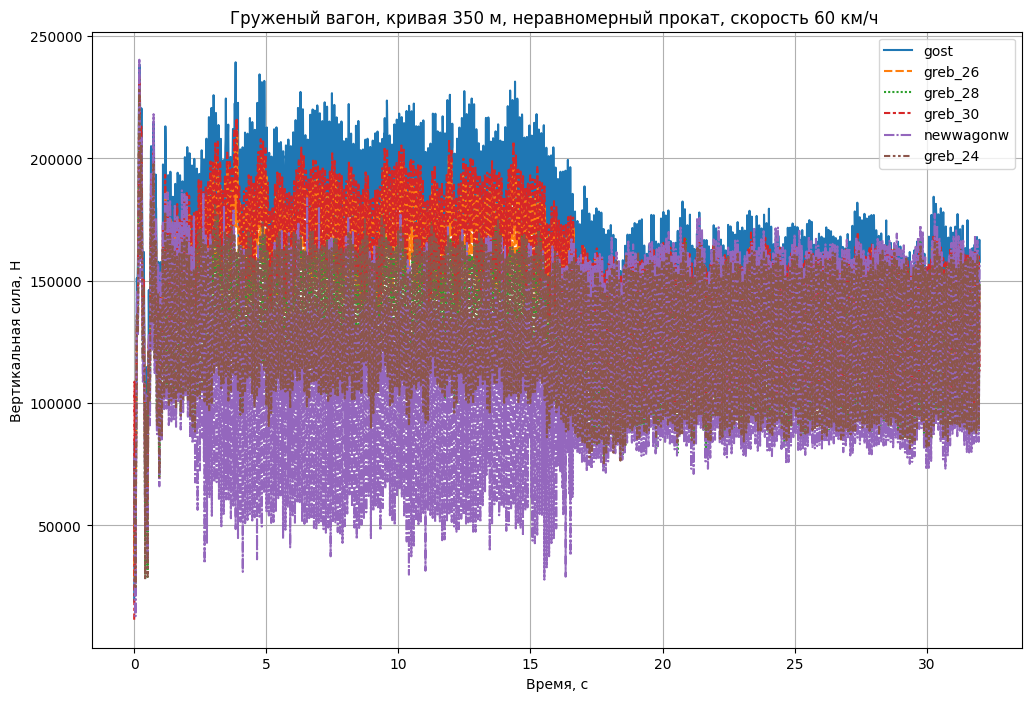

In [5]:
plot_profile_results("loaded","curve_350","ellips10",60)

In [6]:
def get_speed_results(config:str,
                      way_type:str,
                      fault:str,
                      profile:str = "gost") -> list[pd.DataFrame]:
    """Получение расчета сразу по всем скоростям"""
    speed = [i for i in range(10,130,10)]

    results = []

    for v in speed:
        if profile == "greb_24" and v == 120:
            continue
        file = get_result(config,way_type,fault,profile=profile,speed=v)
        results.append(file)
    
    return results

In [7]:
wagon_cfg = ["empty","loaded"]
way_cfg = ["straight","curve_350","curve_650"]

d = {}

for wagon in wagon_cfg:
    d[wagon] = {}
    for way in way_cfg:
        d[wagon][way] = 0

print(d)

{'empty': {'straight': 0, 'curve_350': 0, 'curve_650': 0}, 'loaded': {'straight': 0, 'curve_350': 0, 'curve_650': 0}}


In [8]:
from IPython.display import clear_output

wagon_cfg = ["empty","loaded"]
way_cfg = ["straight","curve_350","curve_650"]
wheel_cfg = ["gost", "greb_26","greb_28","greb_30","newwagonw", "greb_24"]
fault_cfg = ["normal","polzun15","ellips10"]

def get_full_calculations(wagon_cfg:list,
                          way_cfg:list,
                          wheel_cfg:list,
                          fault_cfg:list) -> dict:
    """Получение словаря со всеми расчетами"""
    gen_dict = {}
    

    for wagon in wagon_cfg:
        gen_dict[wagon] = {}
        for way in way_cfg:
            gen_dict[wagon][way] = {}
            for fault in fault_cfg:   
                gen_dict[wagon][way][fault] = {}
                for wheel in wheel_cfg:
                    clear_output(True)
                    print(f"{wagon}\n{way}\n{fault}\n{wheel}\n------")
                    gen_dict[wagon][way][fault][wheel] = get_speed_results(wagon,way,fault,wheel)
    
    return gen_dict

In [9]:
ALL_CALCULATIONS = get_full_calculations(wagon_cfg,way_cfg,wheel_cfg,fault_cfg)

loaded
curve_650
ellips10
greb_24
------


## **Подготовка инфы для разделения на кастомные фолды**

Так как колесо по ГОСТ имеет радиус 475 мм, то полный оборот колеса fold = 2*pi*475

Тогда время прохождения полного оборота колеса будет равно t = fold/v 

In [10]:
def time_split(v:int) -> int:
    """Определение временного промежутка полного оборота колеса
    1. v - скорость движения поезда, км/ч
    """
    speed = v/3.6
    lenght = 2*np.pi*0.475
    t = lenght/speed
    return t

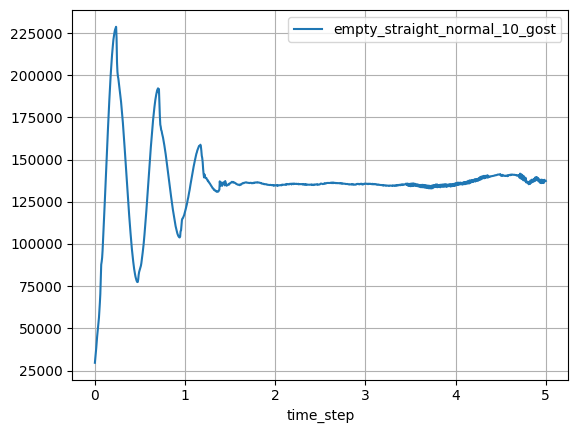

In [11]:
plt.grid(True)
sns.lineplot(ALL_CALCULATIONS["empty"]["straight"]["normal"]["gost"][0])
plt.show()

In [12]:
def get_time_splits(data:pd.DataFrame) -> list:
    """Возвращает индексы по которым нужно производить обрез
    Индексы высчтитываются в зависимости от скорости движения вагона и радиуса колеса"""
    
    res = []

    start_point = 1.4

    time_max_point = data.index.max()               # Максимальное время

    if data.columns[0].split("_")[1] == "straight":
        col_name = data.columns[0].split("_")           # 10,20,30... км/ч
        wheel_rotate_num = time_split(int(col_name[3])) # 1.007 сек

    elif data.columns[0].split("_")[1] == "curve":
        col_name = data.columns[0].split("_")           # 10,20,30... км/ч
        wheel_rotate_num = time_split(int(col_name[4])) # 1.007 сек
        
    num_folds = (time_max_point-1)//wheel_rotate_num    # Сколько всего фолдов получится сделать

    res.append(start_point)

    for _ in range(int(num_folds)):
        start_point+= wheel_rotate_num
        res.append(start_point)

    return res

In [61]:
def time_indexes(frames:list[pd.DataFrame]) -> dict:
    """Возвращает словарь индексов по которым нужно производить обрез, где
    индексы высчтитываются в зависимости от скорости движения вагона и радиуса колеса"""
    
    res = {}

    for n in range(len(frames)):
        str = frames[n].columns[0].split("_")
        for s in str:
            if s.isdigit():                        # тут нужно придумать исключение для толщины гребней
                if int(s) != 350 and int(s) != 650 and int(s) != 24:
                    name = s

                    res[name] = get_time_splits(frames[n])
    
    return res

In [60]:
ALL_CALCULATIONS["empty"]["straight"]["normal"]["greb_24"][1].columns

Index(['empty_straight_normal_20_greb_24'], dtype='object')

In [62]:
time_indexes(ALL_CALCULATIONS["empty"]["straight"]["normal"]["greb_24"])

{'10': [1.4, 2.4744246875277094, 3.5488493750554184, 4.6232740625831275],
 '20': [1.4,
  1.9372123437638544,
  2.474424687527709,
  3.0116370312915635,
  3.548849375055418,
  4.0860617188192725,
  4.6232740625831275,
  5.160486406346982],
 '30': [1.4,
  1.7581415625092363,
  2.1162831250184726,
  2.474424687527709,
  2.8325662500369453,
  3.1907078125461816,
  3.548849375055418,
  3.9069909375646543,
  4.265132500073891,
  4.6232740625831275,
  4.981415625092364,
  5.3395571876016],
 '40': [1.4,
  1.6686061718819272,
  1.9372123437638544,
  2.205818515645782,
  2.4744246875277094,
  2.743030859409637,
  3.0116370312915643,
  3.280243203173492,
  3.5488493750554193,
  3.817455546937347,
  4.086061718819274,
  4.354667890701202,
  4.623274062583129,
  4.891880234465057,
  5.160486406346984],
 '50': [1.4,
  1.6148849375055419,
  1.8297698750110838,
  2.0446548125166255,
  2.2595397500221672,
  2.474424687527709,
  2.6893096250332507,
  2.9041945625387924,
  3.119079500044334,
  3.33396443

In [63]:
def get_all_time_indexes(calculations:dict[dict[dict[dict[list[pd.DataFrame]]]]]) -> dict:
    """Получение всех индексов времени по которым надо делить расчеты в виде словаря"""

    wagon_cfg = calculations.keys()
    way_cfg = calculations["empty"].keys()
    fault_cfg = calculations["empty"]["straight"].keys()
    wheel_cfg = calculations["empty"]["straight"]["normal"].keys()


    gen_dict = {}
    

    for wagon in wagon_cfg:
        gen_dict[wagon] = {}

        for way in way_cfg:
            gen_dict[wagon][way] = {}

            for fault in fault_cfg:   
                gen_dict[wagon][way][fault] = {}
                
                for wheel in wheel_cfg:
                    clear_output(True)
                    print(f"{wagon}\n{way}\n{fault}\n{wheel}\n------")
                    gen_dict[wagon][way][fault][wheel] = time_indexes(calculations[wagon][way][fault][wheel])
    
    return gen_dict

ALL_TIME_INDEXES = get_all_time_indexes(ALL_CALCULATIONS)

loaded
curve_650
ellips10
greb_24
------


In [15]:
def get_splitted_dataframe(data:pd.DataFrame,indexes:list) -> pd.DataFrame:
    """Разделение одного результата расчета на несколько других по полному обороту колеса
    1. `data` - датафрейм с расчетом
    2. `indexes` - индексы по которым нужно делить расчет"""
    
    zeros = np.zeros((214,1))
    common_df = pd.DataFrame(zeros)

    for i in range(len(indexes)):
        if i < len(indexes) - 1:
            seq = data[(data.index>=indexes[i]) & (data.index<=indexes[i+1])]  # срез по точкам
        else:
            seq = data[data.index>indexes[i]]
        common_df = pd.concat([common_df,seq], axis=1)
    
    df = common_df.drop(0, axis=1)
    num_cols = len(df.columns)

    df.columns = [[data.columns[0] for i in range(num_cols)],[i for i in range(num_cols)]]
    
    return df       

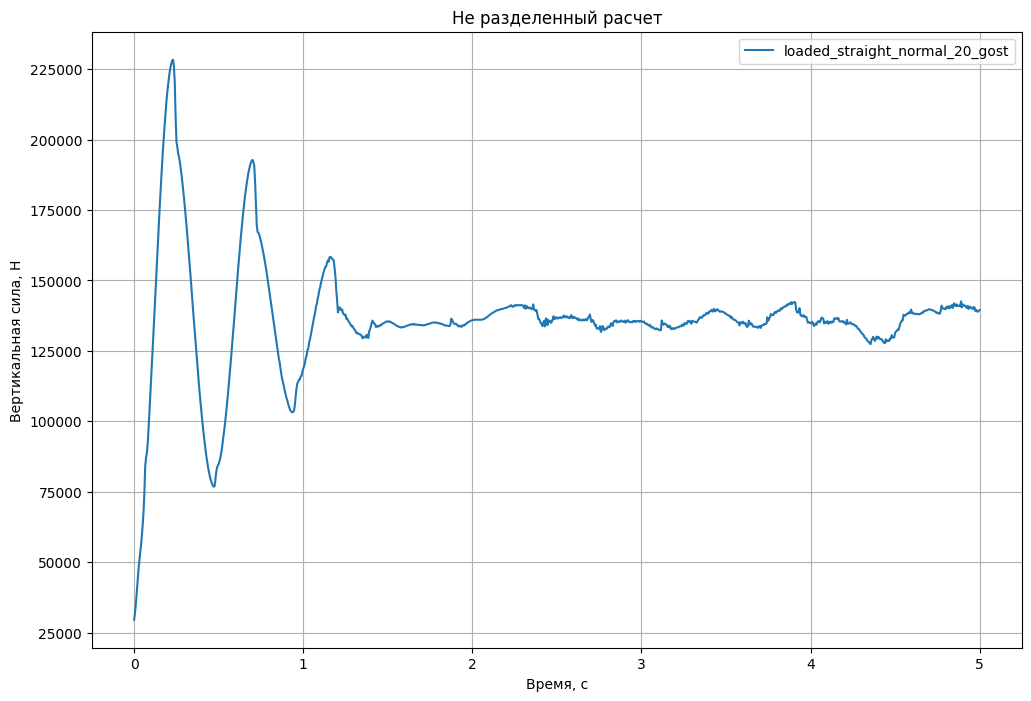

In [16]:
plt.figure().set_size_inches(12,8)
plt.grid(True)
sns.lineplot(ALL_CALCULATIONS["loaded"]["straight"]["normal"]["gost"][1])
plt.title("Не разделенный расчет")
plt.ylabel("Вертикальная сила, Н")
plt.xlabel("Время, с")
plt.show()

**Пример разделения расчета на несколько мелких по обороту колеса**

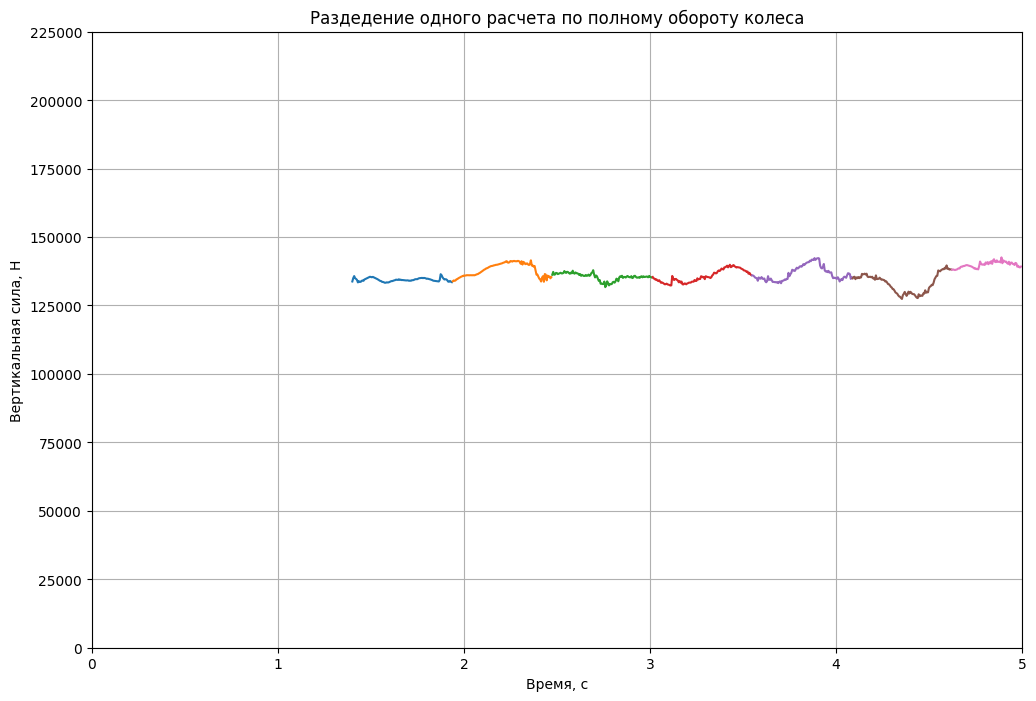

In [17]:
devided_result = get_splitted_dataframe(ALL_CALCULATIONS["loaded"]["straight"]["normal"]["gost"][1],
                                       ALL_TIME_INDEXES["loaded"]["straight"]["normal"]["gost"]["20"])

devided_result_ = get_splitted_dataframe(ALL_CALCULATIONS["loaded"]["straight"]["normal"]["gost"][1],
                                       ALL_TIME_INDEXES["loaded"]["straight"]["normal"]["gost"]["20"])

plt.figure().set_size_inches(12,8)
plt.grid(True)
plt.plot(devided_result)
plt.ylabel("Вертикальная сила, Н")
plt.xlabel("Время, с")
plt.title("Раздедение одного расчета по полному обороту колеса")
plt.xlim(0,5)
plt.ylim(0,225000)
plt.show()

In [18]:
from scipy.stats import skew, kurtosis

def get_skew_kurt(data:pd.DataFrame) -> pd.DataFrame:
    """Получение дополнительных фичей для расчетов"""
    
    cols = data.columns

    skews = []
    kurtosises = []

    for i in cols:
        skew_ = skew(data[i].dropna().to_numpy())
        kurt_ = kurtosis(data[i].dropna().to_numpy())
        skews.append(skew_)
        kurtosises.append(kurt_)
    
    return pd.DataFrame({"skew":skews,"kurt":kurtosises}, index=cols).T

In [19]:
def get_description(data:pd.DataFrame) -> pd.DataFrame:
    """Получаем описанный фрейм и к нему добавляем доп фичи"""
    
    summ = data.sum()
    variance = data.var()
    skew_kurt = get_skew_kurt(data)
    desc = data.describe()

    summ_var = pd.concat([variance,summ],axis=1).T
    summ_var.index = ["var","sum"]
   
    df = pd.concat([desc,summ_var,skew_kurt], axis=0)
    return df

In [86]:
from IPython.display import clear_output

def make_frame_from_splits(calculations:dict,time_indexes:dict) -> pd.DataFrame:
    """Объединение всех разделенных расчетов на фолды и создание фичей"""
    
    wagon_cfg = calculations.keys()
    way_cfg = calculations["empty"].keys()
    fault_cfg = calculations["empty"]["straight"].keys()
    wheel_cfg = calculations["empty"]["straight"]["normal"].keys()
    speed_cfg = time_indexes["empty"]["straight"]["normal"]["gost"].keys()
    lenght = len(calculations["empty"]["straight"]["normal"]["gost"])
    
    zeros = np.zeros((1,12))
    common_df = pd.DataFrame(zeros)

    n = 0

    for wagon in wagon_cfg:
        for way in way_cfg:
            for fault in fault_cfg:
                for wheel in wheel_cfg:
                    for l,speed in zip(range(lenght),speed_cfg):
                        
                        if wheel == "greb_24":
                            if l == 11 and speed == "120":
                                continue
                        
                        splitted_df = get_splitted_dataframe(calculations[wagon][way][fault][wheel][l],
                                                            time_indexes[wagon][way][fault][wheel][speed])
                        
                        feats = get_description(splitted_df)

                        common_df = pd.concat([common_df,feats], axis=1)

                        clear_output(wait=True)
                        print(f"Сделано: {n}")
                        n+=1
                       
    
    df = common_df.drop(0, axis=0).drop(0,axis=1)

    return df                   

In [83]:
len(ALL_TIME_INDEXES["empty"]["straight"]["normal"]["greb_24"].keys())

11

In [84]:
len(ALL_CALCULATIONS["empty"]["straight"]["normal"]["greb_24"])

11

In [87]:
df = make_frame_from_splits(ALL_CALCULATIONS,ALL_TIME_INDEXES)

Сделано: 1277


In [88]:
def make_pretty_df(data:pd.DataFrame, file_name:str, save:bool):
    df_ = data.copy()
    unvalid_cols = [i for i in range(1,12)]

    df_ = df.drop(unvalid_cols,axis=1)

    new_cols = pd.MultiIndex.from_tuples(df_.columns)
    df_.columns = new_cols

    if save:
        df_.T.to_parquet(f"{file_name}")

    return df_.T

In [89]:
DF = make_pretty_df(df,"data_216k_raw.parquet",True)

## **подгрузка сохраненных результатов**

In [43]:
# DF = df_
DF = pd.read_parquet("data_216k_raw.parquet")

In [90]:
DF.head()

25%        50%         75%  count  \
empty_straight_normal_10_gost 0  135122.8700  135435.41  136042.135  215.0   
                              1  134990.1600  135442.38  135746.890  215.0   
                              2  134714.4000  136166.78  139981.480  215.0   
                              3  137077.3900  138094.11  140412.155   76.0   
empty_straight_normal_20_gost 0  134282.8875  134899.11  135300.415  108.0   

                                     kurt        max           mean  \
empty_straight_normal_10_gost 0 -0.706313  137296.64  135550.166558   
                              1 -0.784494  136383.25  135384.156000   
                              2 -1.433097  141437.78  136946.328140   
                              3 -1.239721  141703.59  138486.160789   
empty_straight_normal_20_gost 0  0.585445  137433.47  134835.488981   

                                       min      skew          std  \
empty_straight_normal_10_gost 0  134438.97  0.432877   577.350503   
                              1  134225.06 -0.176132   513.772628   
                              2  132912.20  0.323290  2652.672021   
                              3  135401.31  0.216969  1766.175195   
empty_straight_normal_20_gost 0  133036.84  0.397254   737.810315   

                                         sum           var  
empty_straight_normal_10_gost 0  29143285.81  3.333336e+05  
                              1  29107593.54  2.639623e+05  
                              2  29443460.55  7.036669e+06  
                              3  10524948.22  3.119375e+06  
empty_straight_normal_20_gost 0  14562232.81  5.443641e+05

In [91]:
def delete_unvalid_cols(data:pd.DataFrame) -> pd.DataFrame:
    """Удаление неликвидных колонок"""
    data_copy = data.T.copy()
    unvalid_cols = []

    for i in data_copy.columns:
        if data_copy[i].nunique() < 3:
            unvalid_cols.append(i)
    
    df = data_copy.drop(unvalid_cols, axis=1)

    return df.T


df = delete_unvalid_cols(DF)

df.head(15)
print(df.shape)

(216058, 12)


# Пайплайн для обучения первой модельки 

*Предварительные результаты*

In [92]:
def new_str(value:str):
    """Замена строки типа `loaded_curve_650_normal_30_greb_30` на `loaded_curve650_normal_30_greb_30`"""

    if "curve" in value and "greb" in value:
        splitted = value.split("_")
        way_cfg = splitted[1]
        curve_m = splitted[2]
        new_word_1 = way_cfg+curve_m
        value = value.replace(curve_m,"")
        value = value.replace(way_cfg+"_",new_word_1)

        greb = splitted[5]
        greb_mm = splitted[6]
        new_word_2 = greb+greb_mm
        value = value.replace(greb_mm,"")
        value = value.replace(greb+"_",new_word_2)

        speed = splitted[4]

        if greb_mm == "30" and speed == "30":
            value = value.split("_")
            
            if "" in value:
                value.remove("")
            value.insert(3,"30")
            # print(value)
            value = "_".join(value)

    
    elif "curve" in value:
        splitted = value.split("_")
        way_cfg = splitted[1]
        curve_m = splitted[2]
        new_word_1 = way_cfg+curve_m
        value = value.replace(curve_m,"")
        value = value.replace(way_cfg+"_",new_word_1)

    return value

new_str("loaded_curve_650_normal_30_greb_30")

'loaded_curve650_normal_30_greb30'

In [93]:
df = df.reset_index().drop(["level_1"], axis=1)
df.head(15)

,level_0,25%,50%,75%,count,kurt,max,mean,min,skew,std,sum,var
0,empty_straight_normal_10_gost,135122.8700,135435.410,136042.1350,215.0,-0.706313,137296.64,135550.166558,134438.97,0.432877,577.350503,29143285.81,3.333336e+05
1,empty_straight_normal_10_gost,134990.1600,135442.380,135746.8900,215.0,-0.784494,136383.25,135384.156000,134225.06,-0.176132,513.772628,29107593.54,2.639623e+05
2,empty_straight_normal_10_gost,134714.4000,136166.780,139981.4800,215.0,-1.433097,141437.78,136946.328140,132912.20,0.323290,2652.672021,29443460.55,7.036669e+06
3,empty_straight_normal_10_gost,137077.3900,138094.110,140412.1550,76.0,-1.239721,141703.59,138486.160789,135401.31,0.216969,1766.175195,10524948.22,3.119375e+06
4,empty_straight_normal_20_gost,134282.8875,134899.110,135300.4150,108.0,0.585445,137433.47,134835.488981,133036.84,0.397254,737.810315,14562232.81,5.443641e+05
5,empty_straight_normal_20_gost,135549.2600,138025.000,140465.0400,107.0,-1.405319,142407.47,137972.254673,133769.72,-0.011153,2593.473185,14763031.25,6.726103e+06
6,empty_straight_normal_20_gost,135052.1825,135786.880,136391.3025,108.0,0.602033,140087.44,135700.088241,131971.31,-0.063386,1390.712455,14655609.53,1.934081e+06
7,empty_straight_normal_20_gost,133968.0450,135454.780,137416.4800,107.0,-1.078255,140014.97,135740.734299,132493.09,0.411940,2132.822840,14524258.57,4.548933e+06
8,empty_straight_normal_20_gost,135125.2000,136479.150,139193.8150,108.0,-1.044524,141481.42,136842.750370,132286.78,0.158906,2383.391225,14779017.04,5.680554e+06
9,empty_straight_normal_20_gost,129722.6450,133321.690,135620.4200,107.0,-1.341857,138601.13,132848.003364,127257.25,-0.026621,3460.183292,14214736.36,1.197287e+07


In [94]:
df["level_0"] = df["level_0"].map(new_str)

In [95]:
df

,level_0,25%,50%,75%,count,kurt,max,mean,min,skew,std,sum,var
0,empty_straight_normal_10_gost,135122.87000,135435.410,136042.1350,215.0,-0.706313,137296.64,135550.166558,134438.970,0.432877,577.350503,2.914329e+07,3.333336e+05
1,empty_straight_normal_10_gost,134990.16000,135442.380,135746.8900,215.0,-0.784494,136383.25,135384.156000,134225.060,-0.176132,513.772628,2.910759e+07,2.639623e+05
2,empty_straight_normal_10_gost,134714.40000,136166.780,139981.4800,215.0,-1.433097,141437.78,136946.328140,132912.200,0.323290,2652.672021,2.944346e+07,7.036669e+06
3,empty_straight_normal_10_gost,137077.39000,138094.110,140412.1550,76.0,-1.239721,141703.59,138486.160789,135401.310,0.216969,1766.175195,1.052495e+07,3.119375e+06
4,empty_straight_normal_20_gost,134282.88750,134899.110,135300.4150,108.0,0.585445,137433.47,134835.488981,133036.840,0.397254,737.810315,1.456223e+07,5.443641e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
216053,loaded_curve650_ellips10_110_greb24,72265.99200,90531.695,159777.7000,19.0,-1.535025,178388.73,110945.913263,49749.539,0.248293,46420.051706,2.107972e+06,2.154821e+09
216054,loaded_curve650_ellips10_110_greb24,95108.09575,154595.595,173488.9050,20.0,-1.282012,182467.17,138350.750500,70690.320,-0.569417,40875.790609,2.767015e+06,1.670830e+09
216055,loaded_curve650_ellips10_110_greb24,77500.97250,109589.770,160647.2650,19.0,-1.541632,181474.09,119437.646053,56276.418,0.148220,44916.549631,2.269315e+06,2.017496e+09
216056,loaded_curve650_ellips10_110_greb24,111571.89050,147660.985,175504.3950,20.0,-1.100601,186725.88,139536.173900,64341.691,-0.536784,40998.589004,2.790723e+06,1.680884e+09


In [96]:
new_cols = [f"new_col_{i}" for i in range(6)]

df[new_cols] = df['level_0'].str.split("_", expand=True)

In [97]:
df

,level_0,25%,50%,75%,count,kurt,max,mean,min,skew,std,sum,var,new_col_0,new_col_1,new_col_2,new_col_3,new_col_4,new_col_5
0,empty_straight_normal_10_gost,135122.87000,135435.410,136042.1350,215.0,-0.706313,137296.64,135550.166558,134438.970,0.432877,577.350503,2.914329e+07,3.333336e+05,empty,straight,normal,10,gost,None
1,empty_straight_normal_10_gost,134990.16000,135442.380,135746.8900,215.0,-0.784494,136383.25,135384.156000,134225.060,-0.176132,513.772628,2.910759e+07,2.639623e+05,empty,straight,normal,10,gost,None
2,empty_straight_normal_10_gost,134714.40000,136166.780,139981.4800,215.0,-1.433097,141437.78,136946.328140,132912.200,0.323290,2652.672021,2.944346e+07,7.036669e+06,empty,straight,normal,10,gost,None
3,empty_straight_normal_10_gost,137077.39000,138094.110,140412.1550,76.0,-1.239721,141703.59,138486.160789,135401.310,0.216969,1766.175195,1.052495e+07,3.119375e+06,empty,straight,normal,10,gost,None
4,empty_straight_normal_20_gost,134282.88750,134899.110,135300.4150,108.0,0.585445,137433.47,134835.488981,133036.840,0.397254,737.810315,1.456223e+07,5.443641e+05,empty,straight,normal,20,gost,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216053,loaded_curve650_ellips10_110_greb24,72265.99200,90531.695,159777.7000,19.0,-1.535025,178388.73,110945.913263,49749.539,0.248293,46420.051706,2.107972e+06,2.154821e+09,loaded,curve650,ellips10,110,greb24,None
216054,loaded_curve650_ellips10_110_greb24,95108.09575,154595.595,173488.9050,20.0,-1.282012,182467.17,138350.750500,70690.320,-0.569417,40875.790609,2.767015e+06,1.670830e+09,loaded,curve650,ellips10,110,greb24,None
216055,loaded_curve650_ellips10_110_greb24,77500.97250,109589.770,160647.2650,19.0,-1.541632,181474.09,119437.646053,56276.418,0.148220,44916.549631,2.269315e+06,2.017496e+09,loaded,curve650,ellips10,110,greb24,None
216056,loaded_curve650_ellips10_110_greb24,111571.89050,147660.985,175504.3950,20.0,-1.100601,186725.88,139536.173900,64341.691,-0.536784,40998.589004,2.790723e+06,1.680884e+09,loaded,curve650,ellips10,110,greb24,None


In [98]:
df = df.drop("level_0", axis=1)
df

,25%,50%,75%,count,kurt,max,mean,min,skew,std,sum,var,new_col_0,new_col_1,new_col_2,new_col_3,new_col_4,new_col_5
0,135122.87000,135435.410,136042.1350,215.0,-0.706313,137296.64,135550.166558,134438.970,0.432877,577.350503,2.914329e+07,3.333336e+05,empty,straight,normal,10,gost,None
1,134990.16000,135442.380,135746.8900,215.0,-0.784494,136383.25,135384.156000,134225.060,-0.176132,513.772628,2.910759e+07,2.639623e+05,empty,straight,normal,10,gost,None
2,134714.40000,136166.780,139981.4800,215.0,-1.433097,141437.78,136946.328140,132912.200,0.323290,2652.672021,2.944346e+07,7.036669e+06,empty,straight,normal,10,gost,None
3,137077.39000,138094.110,140412.1550,76.0,-1.239721,141703.59,138486.160789,135401.310,0.216969,1766.175195,1.052495e+07,3.119375e+06,empty,straight,normal,10,gost,None
4,134282.88750,134899.110,135300.4150,108.0,0.585445,137433.47,134835.488981,133036.840,0.397254,737.810315,1.456223e+07,5.443641e+05,empty,straight,normal,20,gost,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216053,72265.99200,90531.695,159777.7000,19.0,-1.535025,178388.73,110945.913263,49749.539,0.248293,46420.051706,2.107972e+06,2.154821e+09,loaded,curve650,ellips10,110,greb24,None
216054,95108.09575,154595.595,173488.9050,20.0,-1.282012,182467.17,138350.750500,70690.320,-0.569417,40875.790609,2.767015e+06,1.670830e+09,loaded,curve650,ellips10,110,greb24,None
216055,77500.97250,109589.770,160647.2650,19.0,-1.541632,181474.09,119437.646053,56276.418,0.148220,44916.549631,2.269315e+06,2.017496e+09,loaded,curve650,ellips10,110,greb24,None
216056,111571.89050,147660.985,175504.3950,20.0,-1.100601,186725.88,139536.173900,64341.691,-0.536784,40998.589004,2.790723e+06,1.680884e+09,loaded,curve650,ellips10,110,greb24,None


In [99]:
df = df.drop("new_col_5", axis=1)
df

,25%,50%,75%,count,kurt,max,mean,min,skew,std,sum,var,new_col_0,new_col_1,new_col_2,new_col_3,new_col_4
0,135122.87000,135435.410,136042.1350,215.0,-0.706313,137296.64,135550.166558,134438.970,0.432877,577.350503,2.914329e+07,3.333336e+05,empty,straight,normal,10,gost
1,134990.16000,135442.380,135746.8900,215.0,-0.784494,136383.25,135384.156000,134225.060,-0.176132,513.772628,2.910759e+07,2.639623e+05,empty,straight,normal,10,gost
2,134714.40000,136166.780,139981.4800,215.0,-1.433097,141437.78,136946.328140,132912.200,0.323290,2652.672021,2.944346e+07,7.036669e+06,empty,straight,normal,10,gost
3,137077.39000,138094.110,140412.1550,76.0,-1.239721,141703.59,138486.160789,135401.310,0.216969,1766.175195,1.052495e+07,3.119375e+06,empty,straight,normal,10,gost
4,134282.88750,134899.110,135300.4150,108.0,0.585445,137433.47,134835.488981,133036.840,0.397254,737.810315,1.456223e+07,5.443641e+05,empty,straight,normal,20,gost
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216053,72265.99200,90531.695,159777.7000,19.0,-1.535025,178388.73,110945.913263,49749.539,0.248293,46420.051706,2.107972e+06,2.154821e+09,loaded,curve650,ellips10,110,greb24
216054,95108.09575,154595.595,173488.9050,20.0,-1.282012,182467.17,138350.750500,70690.320,-0.569417,40875.790609,2.767015e+06,1.670830e+09,loaded,curve650,ellips10,110,greb24
216055,77500.97250,109589.770,160647.2650,19.0,-1.541632,181474.09,119437.646053,56276.418,0.148220,44916.549631,2.269315e+06,2.017496e+09,loaded,curve650,ellips10,110,greb24
216056,111571.89050,147660.985,175504.3950,20.0,-1.100601,186725.88,139536.173900,64341.691,-0.536784,40998.589004,2.790723e+06,1.680884e+09,loaded,curve650,ellips10,110,greb24


In [100]:
df.columns[:12]

Index(['25%', '50%', '75%', 'count', 'kurt', 'max', 'mean', 'min', 'skew',
       'std', 'sum', 'var'],
      dtype='object')

In [101]:
columns = ['25%', '50%', '75%', 'count', 'kurt', 'max', 'mean', 'min', 'skew','std', 'sum', 'var'] + ["wagon_cfg","way_cfg","target","speed","profile"]

df.columns=columns

df

,25%,50%,75%,count,kurt,max,mean,min,skew,std,sum,var,wagon_cfg,way_cfg,target,speed,profile
0,135122.87000,135435.410,136042.1350,215.0,-0.706313,137296.64,135550.166558,134438.970,0.432877,577.350503,2.914329e+07,3.333336e+05,empty,straight,normal,10,gost
1,134990.16000,135442.380,135746.8900,215.0,-0.784494,136383.25,135384.156000,134225.060,-0.176132,513.772628,2.910759e+07,2.639623e+05,empty,straight,normal,10,gost
2,134714.40000,136166.780,139981.4800,215.0,-1.433097,141437.78,136946.328140,132912.200,0.323290,2652.672021,2.944346e+07,7.036669e+06,empty,straight,normal,10,gost
3,137077.39000,138094.110,140412.1550,76.0,-1.239721,141703.59,138486.160789,135401.310,0.216969,1766.175195,1.052495e+07,3.119375e+06,empty,straight,normal,10,gost
4,134282.88750,134899.110,135300.4150,108.0,0.585445,137433.47,134835.488981,133036.840,0.397254,737.810315,1.456223e+07,5.443641e+05,empty,straight,normal,20,gost
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216053,72265.99200,90531.695,159777.7000,19.0,-1.535025,178388.73,110945.913263,49749.539,0.248293,46420.051706,2.107972e+06,2.154821e+09,loaded,curve650,ellips10,110,greb24
216054,95108.09575,154595.595,173488.9050,20.0,-1.282012,182467.17,138350.750500,70690.320,-0.569417,40875.790609,2.767015e+06,1.670830e+09,loaded,curve650,ellips10,110,greb24
216055,77500.97250,109589.770,160647.2650,19.0,-1.541632,181474.09,119437.646053,56276.418,0.148220,44916.549631,2.269315e+06,2.017496e+09,loaded,curve650,ellips10,110,greb24
216056,111571.89050,147660.985,175504.3950,20.0,-1.100601,186725.88,139536.173900,64341.691,-0.536784,40998.589004,2.790723e+06,1.680884e+09,loaded,curve650,ellips10,110,greb24


In [102]:
df = pd.get_dummies(df,columns=["wagon_cfg","way_cfg","profile"],drop_first=True)

In [103]:
df

,25%,50%,75%,count,kurt,max,mean,min,skew,std,...,speed,wagon_cfg_loaded,way_cfg_curve650,way_cfg_straight,profile_greb,profile_greb24,profile_greb26,profile_greb28,profile_greb30,profile_newwagonw
0,135122.87000,135435.410,136042.1350,215.0,-0.706313,137296.64,135550.166558,134438.970,0.432877,577.350503,...,10,0,0,1,0,0,0,0,0,0
1,134990.16000,135442.380,135746.8900,215.0,-0.784494,136383.25,135384.156000,134225.060,-0.176132,513.772628,...,10,0,0,1,0,0,0,0,0,0
2,134714.40000,136166.780,139981.4800,215.0,-1.433097,141437.78,136946.328140,132912.200,0.323290,2652.672021,...,10,0,0,1,0,0,0,0,0,0
3,137077.39000,138094.110,140412.1550,76.0,-1.239721,141703.59,138486.160789,135401.310,0.216969,1766.175195,...,10,0,0,1,0,0,0,0,0,0
4,134282.88750,134899.110,135300.4150,108.0,0.585445,137433.47,134835.488981,133036.840,0.397254,737.810315,...,20,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216053,72265.99200,90531.695,159777.7000,19.0,-1.535025,178388.73,110945.913263,49749.539,0.248293,46420.051706,...,110,1,1,0,0,1,0,0,0,0
216054,95108.09575,154595.595,173488.9050,20.0,-1.282012,182467.17,138350.750500,70690.320,-0.569417,40875.790609,...,110,1,1,0,0,1,0,0,0,0
216055,77500.97250,109589.770,160647.2650,19.0,-1.541632,181474.09,119437.646053,56276.418,0.148220,44916.549631,...,110,1,1,0,0,1,0,0,0,0
216056,111571.89050,147660.985,175504.3950,20.0,-1.100601,186725.88,139536.173900,64341.691,-0.536784,40998.589004,...,110,1,1,0,0,1,0,0,0,0


In [104]:
df["speed"] = df["speed"].astype(int)

In [105]:
def binarize_target(string:str):
    if string == "normal":
        return 0
    else:
        return 1

def encode_target(string:str):
    if string == "normal":
        return 0
    elif string == "polzun15":
        return 1
    elif string == "ellips10":
        return 2

In [106]:
df["target"] = df["target"].map(encode_target)

df

,25%,50%,75%,count,kurt,max,mean,min,skew,std,...,speed,wagon_cfg_loaded,way_cfg_curve650,way_cfg_straight,profile_greb,profile_greb24,profile_greb26,profile_greb28,profile_greb30,profile_newwagonw
0,135122.87000,135435.410,136042.1350,215.0,-0.706313,137296.64,135550.166558,134438.970,0.432877,577.350503,...,10,0,0,1,0,0,0,0,0,0
1,134990.16000,135442.380,135746.8900,215.0,-0.784494,136383.25,135384.156000,134225.060,-0.176132,513.772628,...,10,0,0,1,0,0,0,0,0,0
2,134714.40000,136166.780,139981.4800,215.0,-1.433097,141437.78,136946.328140,132912.200,0.323290,2652.672021,...,10,0,0,1,0,0,0,0,0,0
3,137077.39000,138094.110,140412.1550,76.0,-1.239721,141703.59,138486.160789,135401.310,0.216969,1766.175195,...,10,0,0,1,0,0,0,0,0,0
4,134282.88750,134899.110,135300.4150,108.0,0.585445,137433.47,134835.488981,133036.840,0.397254,737.810315,...,20,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216053,72265.99200,90531.695,159777.7000,19.0,-1.535025,178388.73,110945.913263,49749.539,0.248293,46420.051706,...,110,1,1,0,0,1,0,0,0,0
216054,95108.09575,154595.595,173488.9050,20.0,-1.282012,182467.17,138350.750500,70690.320,-0.569417,40875.790609,...,110,1,1,0,0,1,0,0,0,0
216055,77500.97250,109589.770,160647.2650,19.0,-1.541632,181474.09,119437.646053,56276.418,0.148220,44916.549631,...,110,1,1,0,0,1,0,0,0,0
216056,111571.89050,147660.985,175504.3950,20.0,-1.100601,186725.88,139536.173900,64341.691,-0.536784,40998.589004,...,110,1,1,0,0,1,0,0,0,0


In [107]:
df.dtypes

25%                  float64
50%                  float64
75%                  float64
count                float64
kurt                 float64
max                  float64
mean                 float64
min                  float64
skew                 float64
std                  float64
sum                  float64
var                  float64
target                 int64
speed                  int32
wagon_cfg_loaded       uint8
way_cfg_curve650       uint8
way_cfg_straight       uint8
profile_greb           uint8
profile_greb24         uint8
profile_greb26         uint8
profile_greb28         uint8
profile_greb30         uint8
profile_newwagonw      uint8
dtype: object

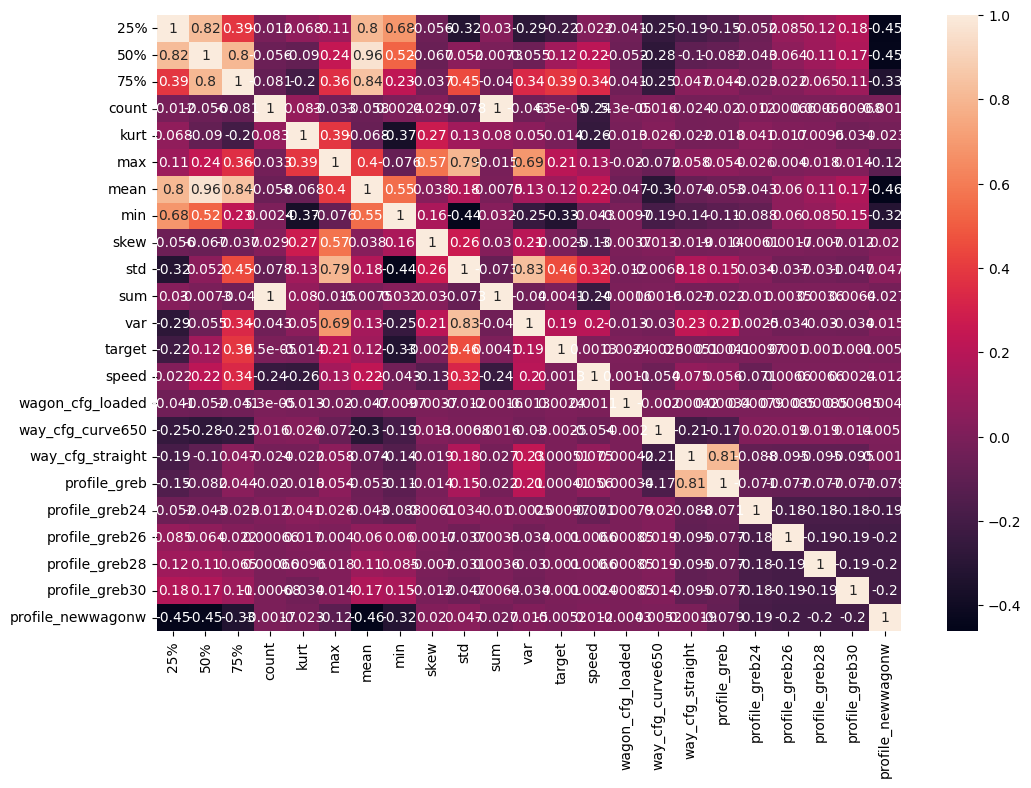

In [108]:
plt.figure().set_size_inches(12,8)
sns.heatmap(df.corr(),annot=True)
plt.show()

In [109]:
from sklearn.metrics import precision_score, recall_score, f1_score

def save_results(estimator,X_test,y_test):
    
    ave = "micro"
    y_pred = estimator.predict(X_test)
    presicion = precision_score(y_test,y_pred,average=ave)
    recall = recall_score(y_test,y_pred,average=ave)
    f1_ = f1_score(y_test,y_pred,average=ave)

    df = pd.read_csv("stat_results.csv")

    shape = X_test.shape[0]
    

    line = pd.DataFrame({"step1":[estimator.steps[0][0]],
                         "step2":[estimator.steps[1][0]],
                         "test_size":[shape],
                         "presicion":[presicion],
                         "recall":[recall],
                         "f1_score":[f1_]})
    
    updated_stats = pd.concat([df,line],axis=0).drop("Unnamed: 0",axis=1).to_csv("stat_results.csv")

    return updated_stats

# Обучение моделей диагностирования неисправностей

In [135]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

np.random.seed(32)

X = df.drop(["target",
             "wagon_cfg_loaded",
             "profile_greb",
             "profile_greb24",
             "profile_greb26",
             "profile_greb28",
             "profile_greb30",
             "profile_newwagonw",
             "count","sum"],axis=1)

y = df["target"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True)

In [136]:
xgb_pipe = Pipeline([("StandardScaler",StandardScaler()),("XGBClassifier",XGBClassifier(booster="gblinear"))])

xgb_pipe.fit(X_train,y_train)

save_results(xgb_pipe,X_test,y_test)

print(classification_report(y_test,xgb_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.93      0.86     14493
           1       0.98      0.86      0.92     14328
           2       0.93      0.87      0.90     14391

    accuracy                           0.89     43212
   macro avg       0.90      0.89      0.89     43212
weighted avg       0.90      0.89      0.89     43212



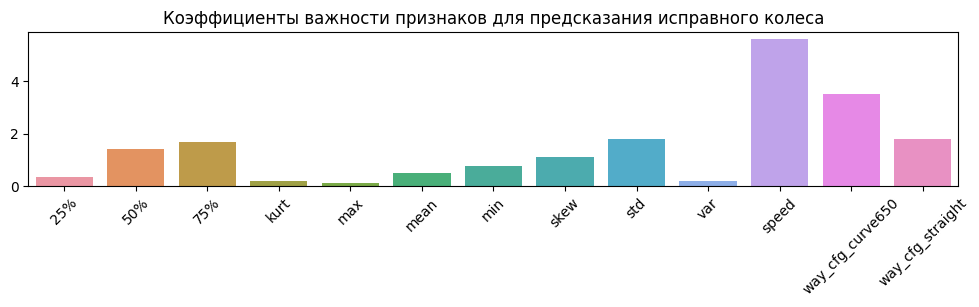

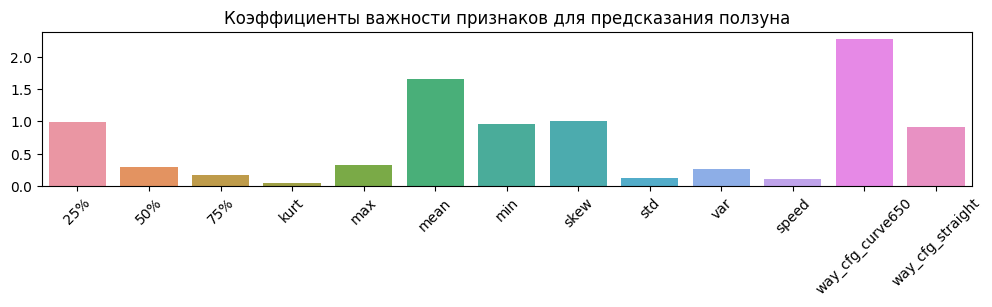

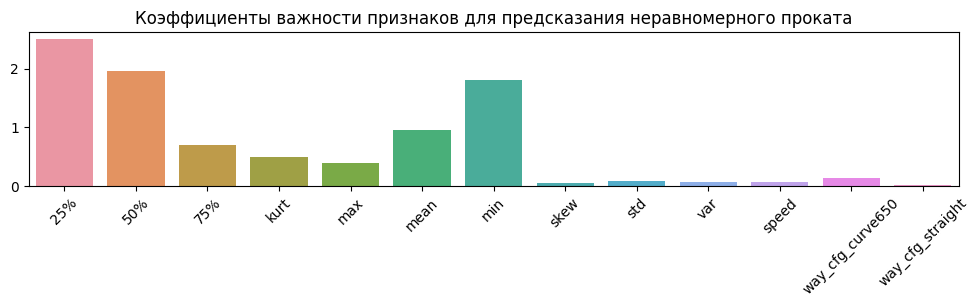

In [137]:
import catboost
import lightgbm
import xgboost
import sklearn

def plot_feature_importance(estimator):
    
    if type(estimator[1]) == xgboost.sklearn.XGBClassifier:
        coefs = estimator[1].coef_

    elif type(estimator[1]) == catboost.core.CatBoostClassifier or lightgbm.sklearn.LGBMClassifier:
        coefs = estimator[1].feature_importances_

    elif type(estimator[1]) == sklearn.linear_model._coordinate_descent.Lasso:
        coefs = estimator[1].coef_
        
    if coefs.shape[0] == 3:
        d = {0:"исправного колеса",
             1:"ползуна",
             2:"неравномерного проката"}
        
    elif coefs.shape[0] == 2:
        d = {0:"исправного вагона",
             1:"неисправного вагона"}
    
    elif len(coefs.shape) == 1:
        d = {0:"модели Catboost"}
    
    if len(coefs) <= 3:
        for i in range(len(coefs)):
            df = pd.DataFrame(coefs[i]).T
            df.columns = estimator[:-1].get_feature_names_out()
            df.index = ["Степень важности"]
            plt.figure().set_size_inches(12,2)
            plt.title(f"Коэффициенты важности признаков для предсказания {d[i]}")
            sns.barplot(abs(df))
            plt.xticks(rotation=45)
            plt.show()
        
    elif len(coefs.shape) == 1:
        df = pd.DataFrame(coefs).T
        df.columns = estimator[:-1].get_feature_names_out()
        df.index = ["Степень важности"]
        plt.figure().set_size_inches(12,2)
        plt.title(f"Коэффициенты важности признаков для предсказания неисправностей {d[0]}")
        sns.barplot(abs(df))
        plt.xticks(rotation=45)
        plt.show()

    else:
        print(len(coefs))
        
plot_feature_importance(xgb_pipe)

In [138]:
from catboost import CatBoostClassifier

cat_pipe = Pipeline([("StandardScaler",StandardScaler()),("CatBoostClassifier",CatBoostClassifier())])

cat_pipe.fit(X_train,y_train)


Learning rate set to 0.102907
0:	learn: 0.9550717	total: 24.6ms	remaining: 24.6s
1:	learn: 0.8478939	total: 49.4ms	remaining: 24.7s
2:	learn: 0.7637457	total: 72.1ms	remaining: 24s
3:	learn: 0.6971683	total: 93.1ms	remaining: 23.2s
4:	learn: 0.6402632	total: 116ms	remaining: 23.1s
5:	learn: 0.5922913	total: 139ms	remaining: 23.1s
6:	learn: 0.5525363	total: 161ms	remaining: 22.9s
7:	learn: 0.5182410	total: 186ms	remaining: 23.1s
8:	learn: 0.4883856	total: 208ms	remaining: 22.9s
9:	learn: 0.4624537	total: 232ms	remaining: 22.9s
10:	learn: 0.4400960	total: 253ms	remaining: 22.7s
11:	learn: 0.4205556	total: 274ms	remaining: 22.6s
12:	learn: 0.4032714	total: 297ms	remaining: 22.6s
13:	learn: 0.3877104	total: 321ms	remaining: 22.6s
14:	learn: 0.3740702	total: 343ms	remaining: 22.5s
15:	learn: 0.3622229	total: 364ms	remaining: 22.4s
16:	learn: 0.3519100	total: 385ms	remaining: 22.3s
17:	learn: 0.3433064	total: 407ms	remaining: 22.2s
18:	learn: 0.3356501	total: 429ms	remaining: 22.1s
19:	learn

Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('CatBoostClassifier',
                 <catboost.core.CatBoostClassifier object at 0x0000026546DD0BD0>)])

In [139]:
print(classification_report(y_test,cat_pipe.predict(X_test)))

save_results(cat_pipe,X_test,y_test)

              precision    recall  f1-score   support

           0       0.84      0.93      0.89     14493
           1       0.98      0.88      0.93     14328
           2       0.94      0.93      0.94     14391

    accuracy                           0.92     43212
   macro avg       0.92      0.92      0.92     43212
weighted avg       0.92      0.92      0.92     43212



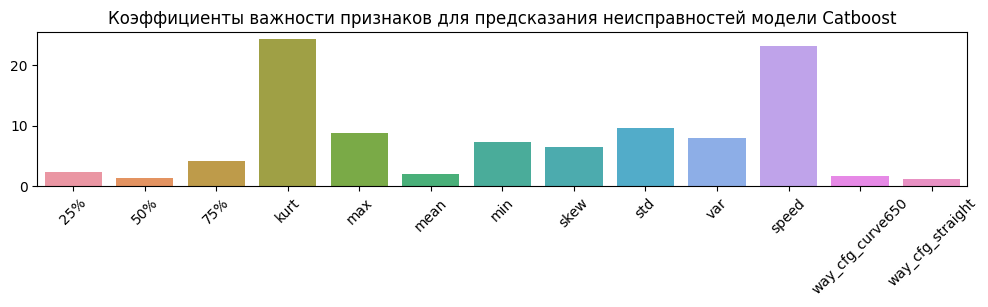

In [142]:
plot_feature_importance(cat_pipe)

In [140]:
from lightgbm import LGBMClassifier
from sklearn.preprocessing import Normalizer

lgbm_pipe = Pipeline([("StandardScaler",StandardScaler()),("LGBMClassifier",LGBMClassifier())])

lgbm_pipe.fit(X_train,y_train)

print(classification_report(y_test,lgbm_pipe.predict(X_test)))

save_results(lgbm_pipe,X_test,y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2569
[LightGBM] [Info] Number of data points in the train set: 172846, number of used features: 13
[LightGBM] [Info] Start training from score -1.095326
[LightGBM] [Info] Start training from score -1.099712
[LightGBM] [Info] Start training from score -1.100807
              precision    recall  f1-score   support

           0       0.84      0.94      0.88     14493
           1       0.98      0.88      0.93     14328
           2       0.94      0.93      0.94     14391

    accuracy                           0.91     43212
   macro avg       0.92      0.91      0.92     43212
weighted avg       0.92      0.91      0.92     43212



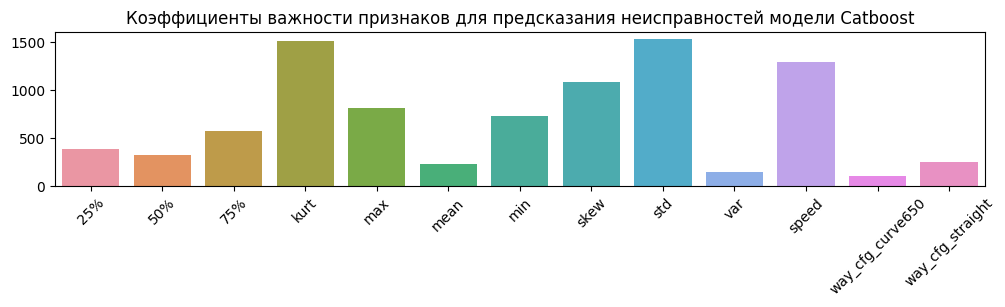

In [141]:
plot_feature_importance(lgbm_pipe)

In [120]:
def show_stat_results():
    data = pd.read_csv("stat_results.csv")
    columns = data.columns

    cols_to_drop = []

    if "Unnamed: 0" in columns:
        print("in")
        for c in columns:
            if "Unnamed" in c:
                cols_to_drop.append(c)
        # print(cols_to_drop)
        return data.drop(cols_to_drop,axis=1)
    
    elif "Unnamed: 0" not in columns:
        return data

show_stat_results()

in


,step1,step2,presicion,recall,f1_score,test_size
0,StandardScaler,CatBoostClassifier,0.924394,0.924394,0.924394,36743.0
1,StandartScaler,LGBMClassifier,0.923577,0.923577,0.923577,36743.0
2,StandardScaler,XGBClassifier,0.895273,0.895273,0.895273,36743.0
3,Normalizer,LGBMClassifier,0.913997,0.913997,0.913997,36743.0
4,StandardScaler,LGBMClassifier,0.923577,0.923577,0.923577,36743.0
5,StandardScaler,XGBClassifier,0.894973,0.894973,0.894973,36743.0
6,StandardScaler,CatBoostClassifier,0.924394,0.924394,0.924394,36743.0
7,StandardScaler,XGBClassifier,0.895409,0.895409,0.895409,36743.0
8,StandardScaler,CatBoostClassifier,0.924394,0.924394,0.924394,36743.0
9,StandardScaler,LGBMClassifier,0.923577,0.923577,0.923577,36743.0


In [73]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, roc_auc_score

fpr,tpr,thresholds = roc_curve(y_true=y_test,y_score=cat_pipe.predict_proba(X_test)[:,1])

auc_roc = roc_auc_score(y_true=y_test,y_score=cat_pipe.predict(X_test))

display = RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=auc_roc, estimator_name="Classifier")

display.plot()
plt.show()

ValueError: multiclass format is not supported

In [ ]:
fpr,tpr,thresholds = roc_curve(y_true=y_test,y_score=xgb_pipe.predict_proba(X_test)[:,1])

auc_roc = roc_auc_score(y_true=y_test,y_score=xgb_pipe.predict(X_test))

display = RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=auc_roc, estimator_name="XGB Classifier")

display.plot()
plt.show()

**PCA TSNE**

In [86]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)

X_embedded

array([[ -36.202747,   35.792503],
       [  17.998075,   87.26539 ],
       [   1.366305,  -38.49477 ],
       ...,
       [ -70.36562 ,  -38.976074],
       [ -52.219196, -109.89604 ],
       [  78.46959 ,  -87.85986 ]], dtype=float32)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

# Initializing Classifiers
clf = XGBClassifier()


# Loading some example data

# print(X)
# print(y)

# Plotting Decision Regions

gs = gridspec.GridSpec(2, 2)
fig = plt.figure().set_size_inches(12,8)

labels = ['Предсказания модели XGboost']
          

for clf, lab, grd in zip([clf],
                         labels,
                         itertools.product([0, 1],
                         repeat=2)):
    clf.fit(X_embedded, y)
    
    # ax = plt.subplot(gs[grd[0], grd[1]])
    plt.plot(grd[0],grd[1])
    fig = plot_decision_regions(X=X_embedded, y=y.to_numpy(),
                                clf=clf, legend=1)
    plt.title(lab)

plt.show()

# Обучение моделей для диагностирования толщины гребней гребней